<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/smart-stats/ds4bio_book/HEAD)

# Convolutions

## 1D transforms
Convolutions are an important topic  in mathematics, statistics, signal processing ... Let's discuss 1D convolutions first. A real valued convolution of two continuous signals, $X(t)$ and $K(t)$ is defined as $X* K$ 

$$
(X* K)(t) = \int_{-\infty}^{\infty} X(u) K(t-u) du
= \int_{-\infty}^{\infty} X(t-v) K(v) dv,
$$

where the equality is determined by a simple change of variable argument. The discrete analog is 

$$
(X* K)(t) = \sum_{u = -\infty}^{\infty} X(u) K(t-u) 
= \sum_{v = -\infty}^{\infty} X(t-v) K(v)
$$

The convolution has many, many uses in data science and statistics. For example, the convolution of densities or mass functions is the respective density or mass function for the sum of random variables from those distributions. In applied data analysis, you can think of the convolution between $X$ and $K$ as *smearing* the function $K$ over the function $X$. Thus, it plays a key role in smoothing. Let's try an example using the covid data and a box kernel.  We take $K(t) = I\{0 \leq t < M\} / M$ (i.e. is 1 for times 0 to $M-1$, then rescaled so it sums to 1). Assume that $N\geq M$ and that $X(t)$ and $K(t)$ are $0$ and for $t < 0$ or $t > N$. Then, our convolution works out to be

$$
(X* K)(t)
= \sum_{u = -\infty}^{\infty} X(u) K(t-u)
= \sum_{u = 0}^{N} X(u) K(t-u)
= \sum_{u = t}^{t + M - 1} X(u) K(t -u)
= \sum_{u = t}^{t + M - 1} X(u) / M
$$

That is, our convolution is a moving average of $X$ where the convolution at point $t$ is the average of the points between $t$ and $t + M - 1$. So, the convolution, as we've defined it, at point $t$ is the moving average at point $t + (M-1)/2$ (ie. it's shifted by $(M-1)/2$). Also, at the end ($t \geq N - M + 1$), we're averaging in the assumed zero values of the $X$. This might be reasonable to do, or maybe not. The fact that we're padding the end and not the beginning is just because of the range of index values we defined the kernel on. We'd have the same problem only on the other end if $K(t) = I(-M < t \leq 0)/M$. Of course, the computer will start summing things at index 0 regardless. However, it can shift the kernel relative to the signal arbitrarily by zero padding one end or the other or both. A reasonable strategy is to set it so that
it averages in $(M-1)/2$ on both ends. Numpy allows you to only look at the range of $N - M$ middle values where this isn't an issue  (argument `mode = "valid"`).

Note we could make the kernel weight points differently than just a box kernel. A popular choice is a Gaussian distribution. 

Also, the convolution has $N+M-1$ points. So, it has more time points than the original signal. Numpy has options to shift the convolution back into the same space as the original signal for you (i.e. has $N$ points, `mode = "same"`). Or, you can just do it yourself if you do `mode = "full"`, just shift by $(M-1)/2$. Similarly shift for `mode = "valid"` (but the convolution has fewer points in this case, so it won't have corresponding points with $X$ at the very beginning and end).

Here's an example using Italy's daily covid case count data. We plot the data and the convolution smoothed data. In the bottom panels, we show the residuals to highlight the difference.



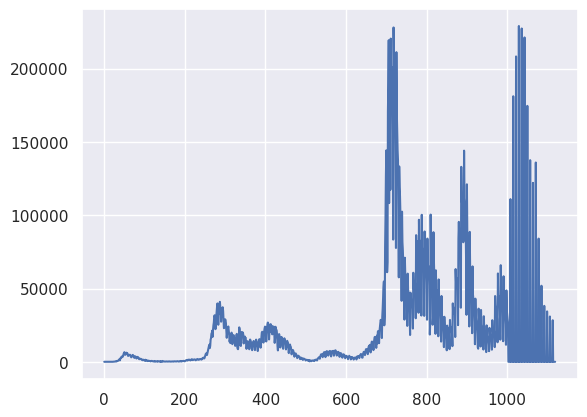

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

dat = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
## Get Italy, drop everyrthing except dates, convert to long (unstack converts to tuple)
X = dat[dat['Country/Region'] == 'Italy'].drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1).unstack()
## convert from tuple to array
X = np.asarray(X)  
## get case counts instead of cumulative counts
X = X[1 : X.size] - X[0 : (X.size - 1)]
## get the first non zero entry
X =  X[np.min(np.where(X !=  0)) : X.size]
plt.plot(X)

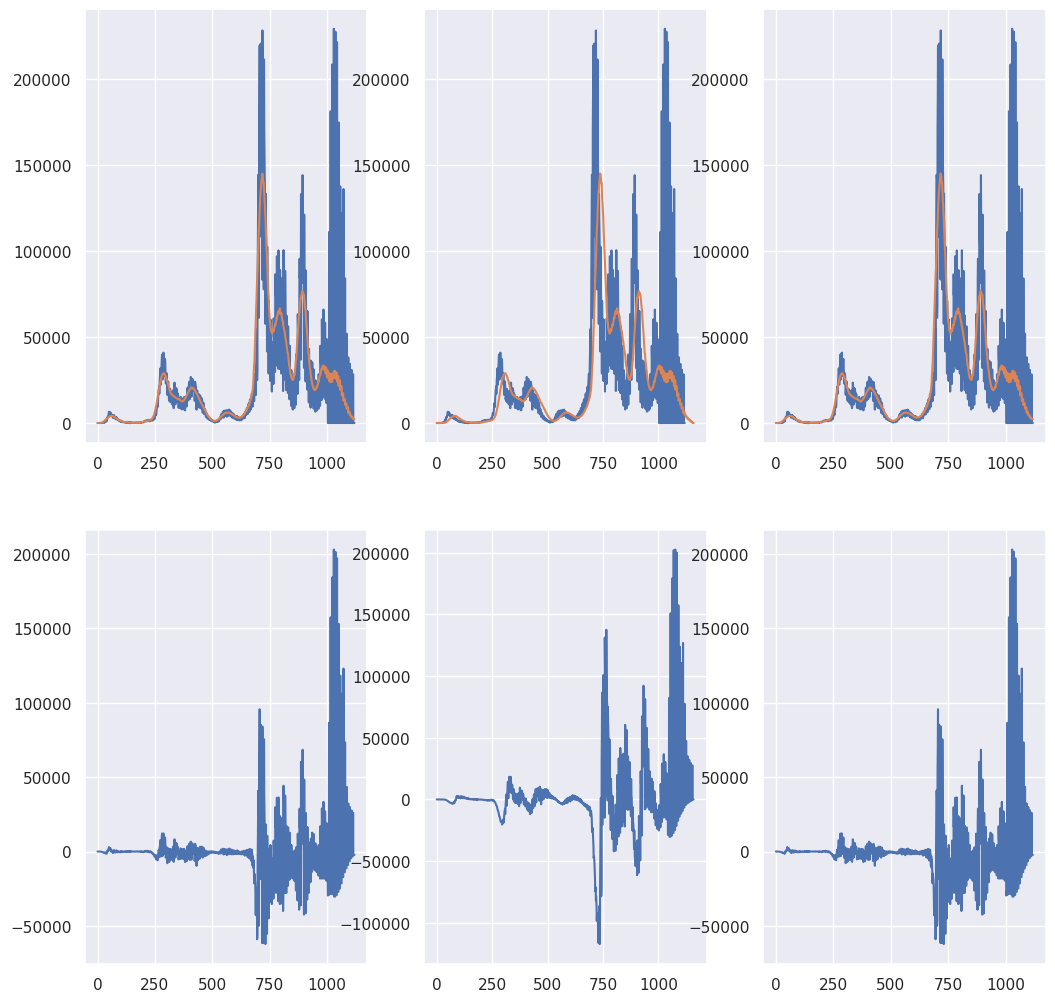

In [2]:

## 41 day moving average
N = len(X)
M = 41

fig, axes = plt.subplots(2, 3, figsize = [12.4, 12.4])
axes[0,0].plot(X)
axes[0,1].plot(X)
axes[0,2].plot(X)

K = np.ones(M) / M

## Plot the convolution with the argument 'same'
## this gives N (assumed greater than M) points
XC = np.convolve(X, K, 'same')
axes[0,0].plot(XC)
axes[1,0].plot(X - XC)

## Plot the convolution with the argument 'full'
## which gives N+M-1 total pionts
XC = np.convolve(X, K, 'full')
temp = np.pad(X, (M-1, 0), 'constant') 
axes[0,1].plot(XC)
axes[1,1].plot(temp- XC)


## Plot the convolution with the convolution shifted back by (M-1)/2
XCshifted = XC[ (int((M - 1)/2)) : int(len(XC) - (M - 1)/2) ]
axes[0, 2].plot(XCshifted)
axes[1, 2].plot(X - XCshifted)


Let's show that the first point and end point of the convolution are the averages of $(M-1)/2$ points and and $(M-1)/2+1$ zeros at the beginning or end of the original signal just to show that our intuition is correct. 


In [3]:
temp = np.convolve(X, K, 'same')
[
  # the first convolution point (temp[0]) and the average of the
  # the first (M-1) / 2 X points and (M-1)/2 + 1 zeros
  [temp[0],     X[0 : int(    (M - 1) / 2)].sum() / M],
  # the last convolution point (temp[N-1]) and the average of the
  # the last (M-1) / 2 X points and (M-1)/2 + 1 zeros
  [temp[N - 1], X[int(N - (M - 1) / 2 - 1)  : N].sum() / M]
 
]


[[0.07317073170731708, 0.07317073170731707],
 [2283.536585365854, 2283.5365853658536]]

Also, I averaged a lot (41 days) in order to make the shift very apparent. Let's look at the performance for less wide of a kernel.

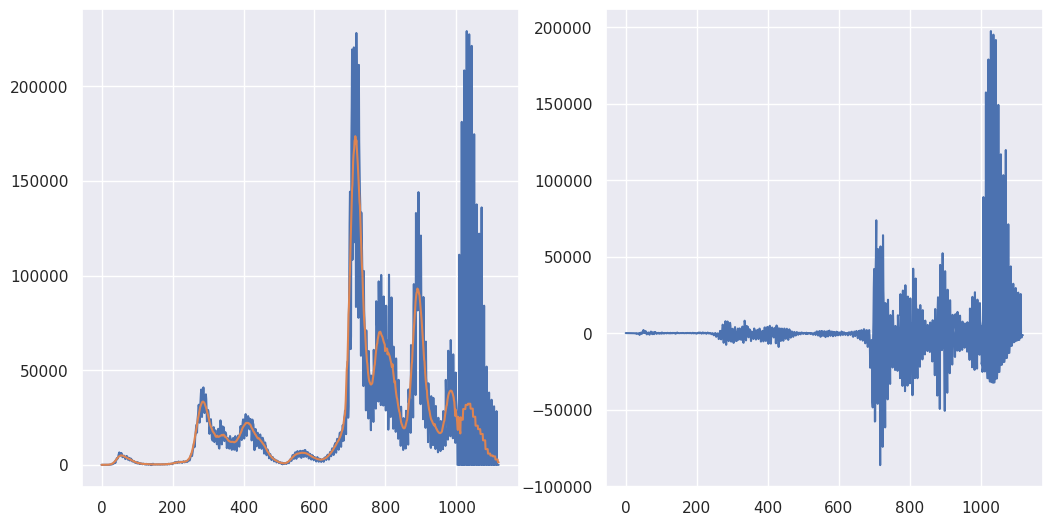

In [4]:
## 21 day moving average
M = 21
K = np.ones(M) / M

fig, axes = plt.subplots(1, 2, figsize = [12.4, 6.2])
XC = np.convolve(X, K, 'same')
axes[0].plot(X)
axes[0].plot(XC)
axes[1].plot(X - XC)

It should be stated that the convolution operation is multiplication in Fourier space. So, functions like `np.convolve` are performing FFTs in the background. However, if you're going to do this yourself, make sure to keep track of indices and zero padding. (I.e. the bookkeeping.) Otherwise, the FFT wraps around and you get a little of the end averaged in with the beginning and vice versa. I work out getting the same answer as `mode = "same"` below.


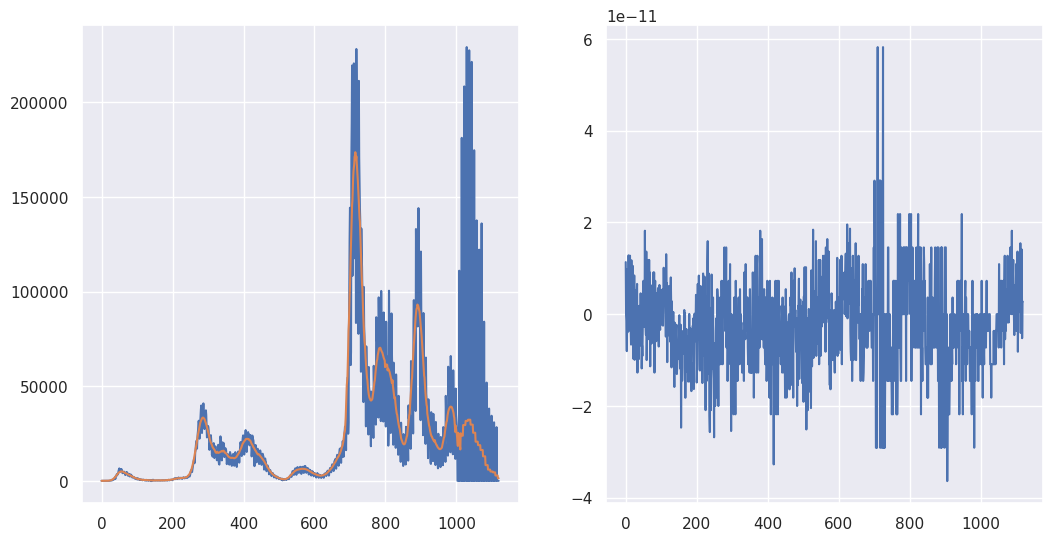

In [5]:
fig, axes = plt.subplots(1, 2, figsize = [12.4, 6.2])

## Pad the X with zeros in the back, need at least M-1 
pad_width = (0, M - 1)
Xpadded = np.pad(X, pad_width, "constant")
## Pad the kernel in the back with N-1, so both the kernel
## and the X are of length, N+M-1
Kpadded = np.pad(K, (0, N - 1))

## Note we take the real part b/c the complex part is all effectively 
## machine 0
convolution = np.fft.ifft(np.fft.fft(Xpadded) * np.fft.fft(Kpadded)).real

## At this point the convolution is of length N + M - 1
## To get it comparable with the original X, subtract (M-1)/2 indices
## from each end
convolution = convolution[ int((M-1)/2) : int(N+(M-1)/2)]

## Let's see how we did
axes[0].plot(X)
axes[0].plot(convolution)

#Show they're the same by plotting the subtraction
axes[1].plot(convolution - XC)

## 2D transforms
For two dimensions, the convolution is similar

$$
(X ** K)(i,j) = \sum_{u=-\infty}^{\infty} \sum_{v=-\infty}^{\infty} 
X(u, v)  K(i -u, k - v) = \sum_{u=-\infty}^{\infty} \sum_{v=-\infty}^{\infty} 
K(u, v)  X(i -u, k - v)  
$$

Once again, let's think where $X$ is of dimension $(N_1, N_2)$ and 0 outside of that range, and 

$$
K(u, v) = I(0 \leq u < M_1, 0 \leq v < M_2) / (M_1 M_2)
$$

(i.e. $K$ is a box on $M_1 \leq N_1$, $M_2 < N_2$). Then, applying the exact same argument as before,  the convolution is:

$$
(X ** K)(i,j) = \sum_{u=i}^{M_1 + i - 1} \sum_{v=j}^{M_2 + j - 1} 
X(u, v) / (M_1 M_2) 
$$

That is, the convolution at point $(i,j)$ is the average of the neighboring points. Also, all of the same bookkeeping, zero padding and Fourier transform stuff apply (using the 2D FFT).

For regular kernels (box kernels, 2D Gaussians), convolution smooths the image, which has the efffect of making it blurrier. The kernel width determines how blurry the image will then be. This is typically done to denoise an image (to blur out the noise). Let's try it on a cartoon image of Brian. We'll just stick to a black and white image so that it's 2D. A color image has 3 color channels, so is a 3D array. (However, you see the patten; you should be able to extend this to 3D with little problem.)

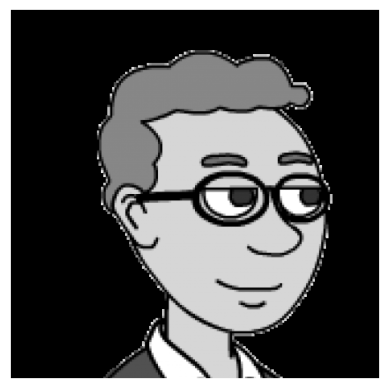

In [6]:
import PIL
import scipy.signal as sp
import urllib.request


imgURL = "https://github.com/smart-stats/ds4bio_book/raw/main/book/bcCartoon.png"
urllib.request.urlretrieve(imgURL, "bcCartoon.png")
img = np.asarray(PIL.Image.open("bcCartoon.png").convert("L"))

plt.xticks([])
plt.yticks([])
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

Text(0.5, 1.0, '32x32')

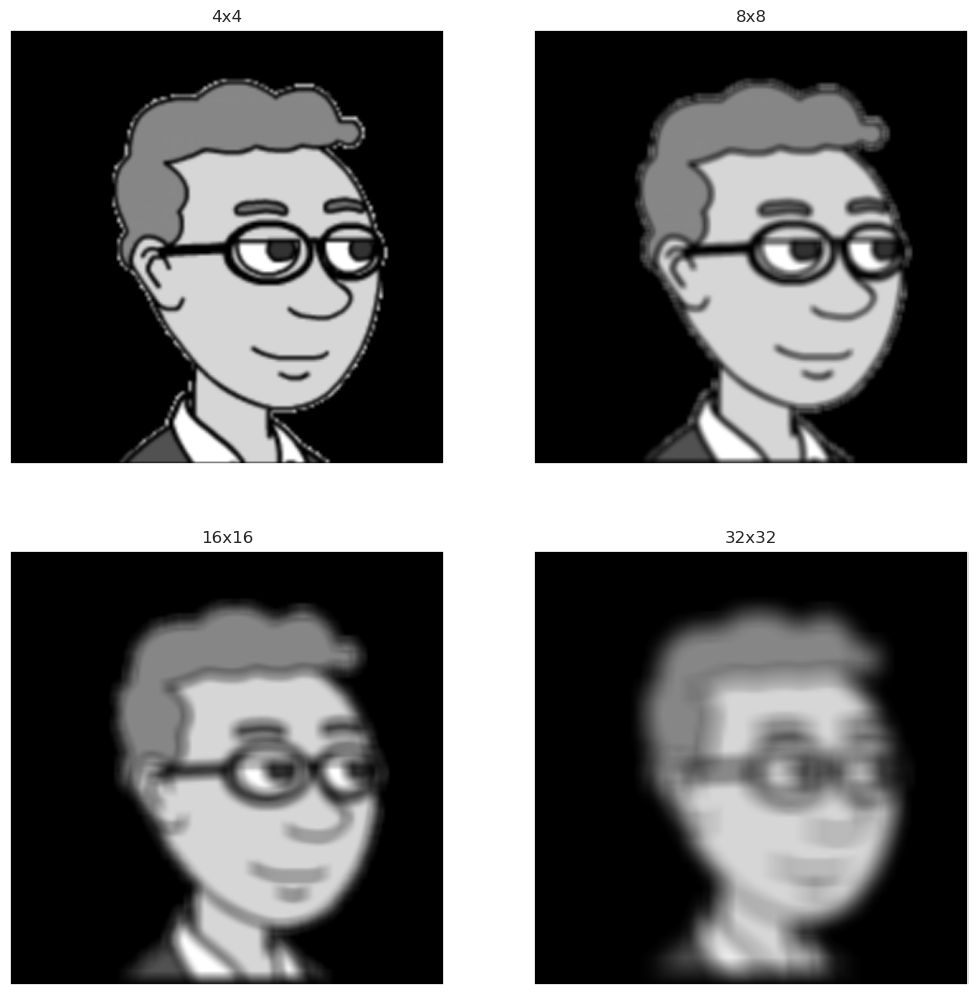

In [7]:
def kernel(i, j):
  return np.ones((i, j)) / np.prod([i, j])

plt.figure(figsize=[12.4, 12.4])
imgC = sp.convolve2d(img, kernel(4, 4))
plt.subplot(2, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(imgC, cmap='gray', vmin=0, vmax=255)
plt.title("4x4")

imgC = sp.convolve2d(img, kernel(8, 8))
plt.subplot(2, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(imgC, cmap='gray', vmin=0, vmax=255)
plt.title("8x8")

imgC = sp.convolve2d(img, kernel(16, 16))
plt.subplot(2, 2, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(imgC, cmap='gray', vmin=0, vmax=255)
plt.title("16x16")

boxsize = (5, 5)
imgC = sp.convolve2d(img, kernel(32,32))
plt.subplot(2, 2, 4)
plt.xticks([])
plt.yticks([])
plt.imshow(imgC, cmap='gray', vmin=0, vmax=255)
plt.title("32x32")


## Convolutional neural networks

Of course, your kernel doesn't have to be a box, or a truncated, discretized bivariate Gaussian density or even be non-negative. It's helpful for smoothers to have non-negative kernels, since they're just taking a generalized variation of a moving average that way. But, we want to use convolutions 

more generally.  Here, let's take a kernel that is part of the image (left eye) and convolve it. I'll make the kernel super peaked at eye features by extracting the eye and raising it to the 4th power.

So a relu activation function plus a bias term would then be able to highlight different thresheld variations of this convolution image. For example, here I add a bias term to the convolution then apply a leaky relu. You can see it just highlights the one area where the eye is. A leaky relu is 

$$
lrelu(x, c) = \left\{
  \begin{array}{ll}
  x & \text{if $x > 0$} \\
  x * c & \text{otherwise}
  \end{array}
  \right.
$$

where $c$ is usually set to a small value. If $c=0$ the leaky relu is just the relu. I set $c$ to be 0.05 so that we can see the background image.

Text(0.5, 1.0, 'LRELU of convolution + bias')

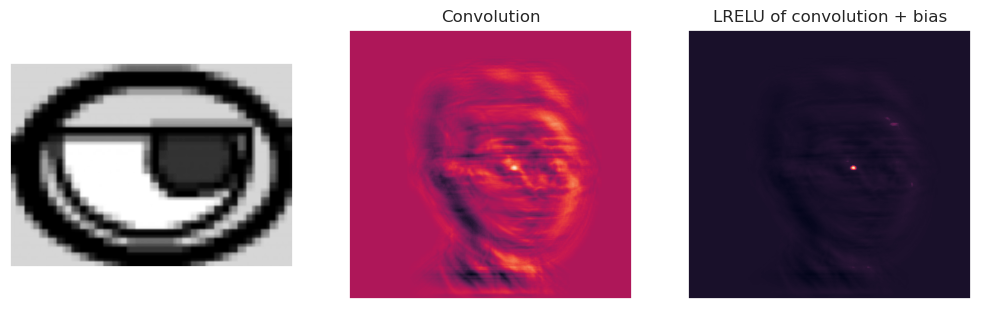

In [8]:

plt.figure(figsize=[12.4, 6.2])

K = img[200 : 270,225 : 322]
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(K,  cmap='gray', vmin=0, vmax=255)
## I normalized it this way so that the convolution
## numbers wouldn't be so big
## Also, I put it to the 4th power, so it exactly finds 
## the eye.
K = K ** 4
K = K / K.sum()
K = K - K.mean()

imgC = sp.convolve2d(img, K)
plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(imgC)
plt.title("Convolution")

temp = imgC.copy()
## Add a bias term of -15
temp -= 15
## Perform a leaky relu
temp[np.where(temp < 0)] = temp[np.where(temp < 0)] * .05

plt.subplot(1, 3, 3)
plt.imshow(temp)
plt.xticks([])
plt.yticks([])
plt.title("LRELU of convolution + bias")



Because of how convolutions work, this will find this eye anywhere in the image. Here we just add another eye somewhere else and repeat the convolution.

Text(0.5, 1.0, 'LRELU of convolution + bias')

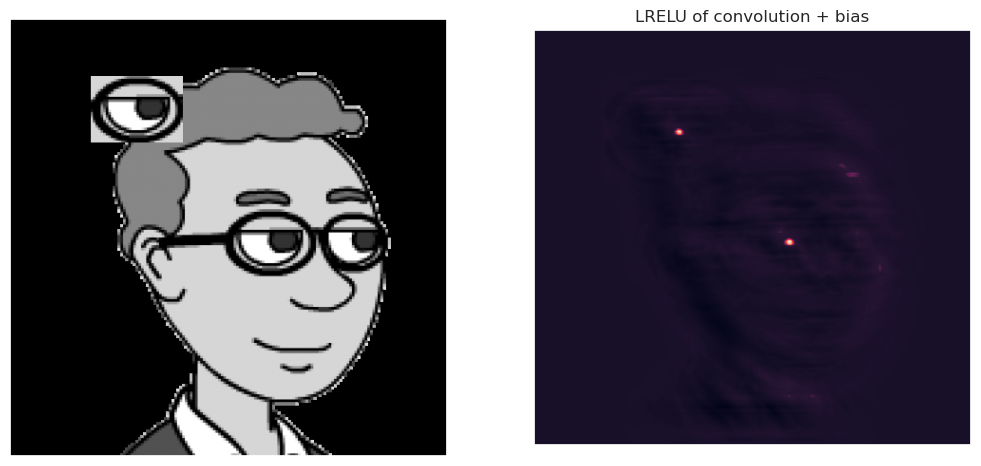

In [9]:
plt.figure(figsize=[12.4, 6.2])

#put another eye in the image
imgCopy = img.copy()
imgCopy[60 : 130, 85 : 182] = img[200 : 270,225 : 322]
plt.subplot(1, 2, 1)
plt.imshow(imgCopy,  cmap='gray', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])

imgC = sp.convolve2d(imgCopy, K)

plt.subplot(1, 2, 2)
temp = imgC.copy()
## Add a bias term of -15
temp -= 15
## Perform a leaky relu
temp[np.where(temp < 0)] = temp[np.where(temp < 0)] * .05

plt.subplot(1, 2, 2)
plt.imshow(temp)
plt.xticks([])
plt.yticks([])
plt.title("LRELU of convolution + bias")

So, we found a custom kernel that highlights this specific feature in images. Convnets layers learn the kernel. That is, CNNs learn the image that gets convolved with the previous layer to produce the next one. [Here's](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) a really great pictorial guide by Sumit Saha. 

Now, let's discuss some specific vocabulary used in CNNs.

* **Padding** zero padding just like we discussed for 1D transformations
* **Pooling** pooling, often max pooling, is a dimension reduction technique, taking the max in little blocks. 
* **stride length** instead of sliding the kernel by moving it one pixel at a time, move it more to increase computational efficiency and reduce the size of the output convolution.
